# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.495676,False,0.114497
1,0.271500,True,6.111279
2,0.405087,True,4.467770
3,1.437909,True,10.856139
4,0.853315,False,5.036457
...,...,...,...
995,0.683802,False,0.712246
996,-0.649195,False,-3.760712
997,1.223760,False,4.286952
998,2.577242,True,11.527125


<AxesSubplot: xlabel='v0'>

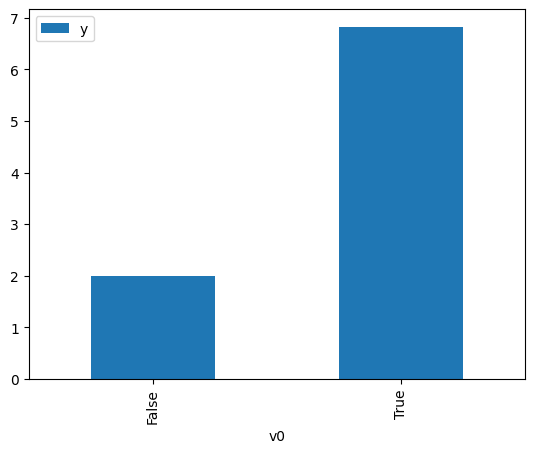

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

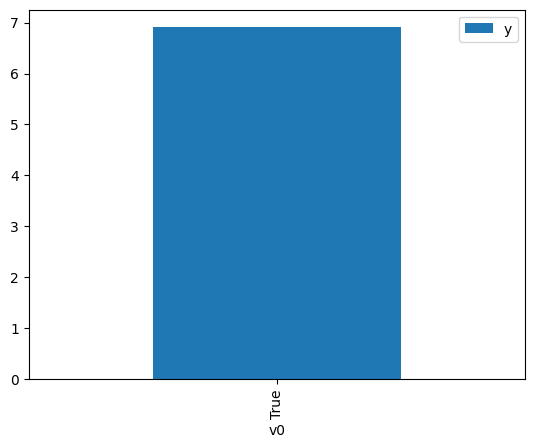

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.962677,False,2.731163,0.488649,2.046457
1,0.963060,False,1.285152,0.488636,2.046512
2,1.333450,False,2.819011,0.476049,2.100623
3,1.113292,False,4.793211,0.483528,2.068131
4,-0.076380,False,1.492980,0.523985,1.908450
...,...,...,...,...,...
995,0.495474,False,1.407595,0.504545,1.981984
996,0.093358,False,2.586551,0.518220,1.929683
997,-0.649195,False,-3.760712,0.543386,1.840313
998,-0.313608,False,-1.064077,0.532032,1.879586


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.800934,True,9.604396,0.539792,1.852566
1,0.908676,True,7.848732,0.509514,1.962655
2,1.486907,True,8.214336,0.529158,1.889796
3,2.860181,True,11.082506,0.575341,1.738098
4,0.605184,True,8.075637,0.499188,2.003253
...,...,...,...,...,...
995,0.762801,True,6.146325,0.504551,1.981959
996,-1.252360,True,2.651436,0.436328,2.291852
997,-0.702970,True,1.747041,0.454799,2.198774
998,1.964816,True,8.846990,0.545328,1.833759


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.518e+04
Date:                Mon, 27 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:34:22   Log-Likelihood:                         -1439.3
No. Observations:                1000   AIC:                                      2883.
Df Residuals:                     998   BIC:                                      2892.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3676      0.029     82.056      0.000       2.311       2.424
x2             4.9885      0.052     96.714      0.000       4.887       5.090
==============================================================================
Omnibus:                        2.708   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.655
Skew:                          -0.079   Prob(JB):                        0.265
Kurtosis:                       3.197   Cond. No.                         2.21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""